In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re


In [ ]:
# 判断词语是否是有效关键词（中文，非数字/符号，长度 > 1）
def is_valid_keyword(word):
    return (
        re.search(r'[\u4e00-\u9fa5]', word)
        and not re.fullmatch(r'[\d\W_]+', word)
        and len(word.strip()) > 1
    )
# 从正文中提取关键词，标签里的内容也做分词
def extract_keywords_with_tag_split(text, topk=5):
    text = str(text)
    tags = re.findall(r"#(.*?)#", text)

    # 分词标签
    tag_words = []
    for tag in tags:
        tag_words += [w for w in jieba.cut(tag) if is_valid_keyword(w)]

    # 去除标签文本
    clean_text = re.sub(r"#.*?#", "", text)
    raw_keywords = jieba.analyse.extract_tags(clean_text, topK=topk)
    keywords = [kw for kw in raw_keywords if is_valid_keyword(kw)]

    return list(set(tag_words + keywords))  # 去重合并


In [ ]:
# 读取微博数据（尝试多个编码）
try:
    df = pd.read_csv("weibo.csv", encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv("weibo.csv", encoding="gb18030")  # 中文备用编码

# 只保留需要的列，并去除正文为空的行
required_cols = ["微博id", "微博正文", "发布时间", "点赞数", "转发数", "评论数"]
df = df[required_cols].dropna(subset=["微博正文"]).reset_index(drop=True)
df.head()


,微博id,微博正文,发布时间,点赞数,转发数,评论数
0,Pjqei3467,#王者荣耀# 官宣！地球常驻民今日正式上岗——峡谷轰炸专家·卤蛋灵魂治愈歌姬·菜姬全球最佳组...,2025-03-20 15:12,2592,897,744
1,PjpWYr62e,#王者钟馗S39赛季皮肤##钟馗虚灵犬护皮肤#S39新赛季【妙手空空】即将开启，本狐为大家带...,2025-03-20 14:30,5335,96,1039
2,Pjp6egKTv,#可口可乐王者荣耀联动##无糖开黑好喝带你飞#好喝到让无限王者团原地起飞！在王者荣耀带飞全场...,2025-03-20 12:20,11608,9833,984
3,Pji4BBbZr,#刘禅米莱狄新源梦皮肤##王者源梦皮肤大赛投票#播报员小妲己带来【源梦首轮投票】最新情报！截...,2025-03-19 18:26,2450,22,520
4,PjhdAgpkb,#首个KPL选手定制播报##谁是KPL春季赛之星#【2025KPL春季赛之星】活动重磅来袭！...,2025-03-19 16:16,2370,49,331


In [ ]:
# 加载停用词表（推荐自己准备更全的，也可以先用一个简单版本）
stopwords = set(["的", "了", "在", "是", "我", "也", "就", "和", "都", "一个", "没有", "你", "我们", "你们", "他们", "还有"])

def clean_and_extract_keywords(text):
    if pd.isna(text):
        return []

    # 删除特殊符号，仅保留中文字符
    text = re.sub(r"[^\u4e00-\u9fa5#]", " ", text)  # 保留中文和#（为了保留tag）

    # 提取 #tag# 标签
    tags = re.findall(r"#(.*?)#", text)

    # 去除标签中的标点，并切词
    tag_words = []
    for tag in tags:
        tag = re.sub(r"[^\u4e00-\u9fa5]", "", tag)
        tag_words.extend([w for w in jieba.cut(tag) if len(w) >= 2 and w not in stopwords])

    # 提取正文部分，分词并过滤
    clean_text = re.sub(r"#.*?#", "", text)  # 去掉tag，避免重复
    words = [w for w in jieba.cut(clean_text) if len(w) >= 2 and w not in stopwords and re.match(r"^[\u4e00-\u9fa5]{2,}$", w)]

    return tag_words + words

In [ ]:
# 对每条微博提取关键词
df["关键词列表"] = df["微博正文"].apply(clean_and_extract_keywords)

df[["微博正文", "关键词列表"]].head()


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 2.458 seconds.
DEBUG:jieba:Loading model cost 2.458 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,微博正文,关键词列表
0,#王者荣耀# 官宣！地球常驻民今日正式上岗——峡谷轰炸专家·卤蛋灵魂治愈歌姬·菜姬全球最佳组...,"[王者, 荣耀, 官宣, 地球, 常驻, 今日, 正式, 上岗, 峡谷, 轰炸, 专家, 卤..."
1,#王者钟馗S39赛季皮肤##钟馗虚灵犬护皮肤#S39新赛季【妙手空空】即将开启，本狐为大家带...,"[王者, 钟馗, 赛季, 皮肤, 钟馗, 虚灵, 犬护, 皮肤, 赛季, 妙手空空, 即将,..."
2,#可口可乐王者荣耀联动##无糖开黑好喝带你飞#好喝到让无限王者团原地起飞！在王者荣耀带飞全场...,"[可口可乐, 王者, 荣耀, 联动, 无糖, 开黑, 好喝, 这么, 好喝, 居然, 无糖,..."
3,#刘禅米莱狄新源梦皮肤##王者源梦皮肤大赛投票#播报员小妲己带来【源梦首轮投票】最新情报！截...,"[刘禅, 米莱, 新源, 皮肤, 王者, 源梦, 皮肤, 大赛, 投票, 播报, 员小妲己,..."
4,#首个KPL选手定制播报##谁是KPL春季赛之星#【2025KPL春季赛之星】活动重磅来袭！...,"[首个, 选手, 定制, 播报, 春季, 赛之星, 春季, 赛之星, 活动, 重磅, 来袭,..."


In [ ]:
# 保存结果
df.to_csv("关键词趋势分析.csv", index=False, encoding="utf-8-sig")
print("✅ 已完成关键词提取，结果保存在：关键词趋势分析.csv")


✅ 已完成关键词提取，结果保存在：关键词趋势分析.csv


In [ ]:
from collections import Counter

# 展平所有关键词，形成一个大列表
all_keywords = [kw for kws in df["关键词列表"] for kw in kws]

# 统计频次
keyword_counter = Counter(all_keywords)

# 取前K个热词
top_k = 20
top_keywords = keyword_counter.most_common(top_k)

# 显示结果
for i, (word, freq) in enumerate(top_keywords, 1):
    print(f"{i}. {word} — {freq}次")


1. 王者 — 6933次
2. 皮肤 — 4032次
3. 荣耀 — 3555次
4. 活动 — 3172次
5. 设计 — 2147次
6. 原图 — 1693次
7. 小伙伴 — 1617次
8. 本狐 — 1560次
9. 英雄 — 1514次
10. 一起 — 1373次
11. 大家 — 1370次
12. 开启 — 1160次
13. 峡谷 — 1151次
14. 上线 — 1143次
15. 游戏 — 1111次
16. 参与 — 916次
17. 限时 — 903次
18. 技能 — 897次
19. 关注 — 893次
20. 福利 — 870次


In [ ]:
# # 下载--解压--移动字体文件
# !wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
# !unzip "simhei.zip"
# !rm "simhei.zip"



In [ ]:
# !mv simhei.ttf /usr/share/fonts/truetype/

In [ ]:
# !head -c 100 simhei.ttf | xxd


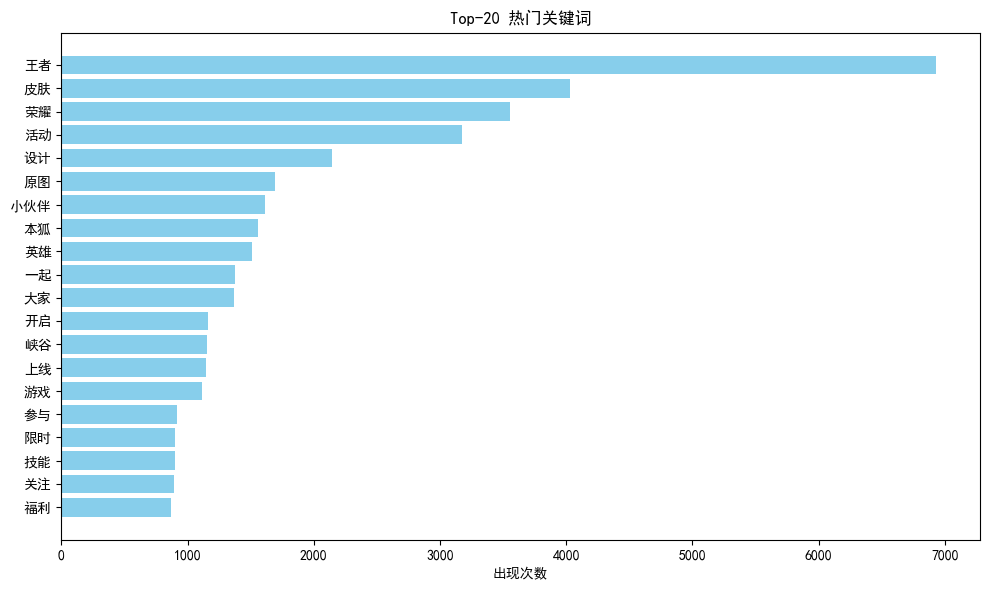

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 解包关键词和频次
words, freqs = zip(*top_keywords)

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], freqs[::-1], color='skyblue')
plt.xlabel("出现次数")
plt.title(f"Top-{top_k} 热门关键词")
plt.tight_layout()
plt.show()


In [ ]:
df

,微博id,微博正文,发布时间,点赞数,转发数,评论数,关键词列表
0,Pjqei3467,#王者荣耀# 官宣！地球常驻民今日正式上岗——峡谷轰炸专家·卤蛋灵魂治愈歌姬·菜姬全球最佳组...,2025-03-20 15:12,2592,897,744,"[王者, 荣耀, 官宣, 地球, 常驻, 今日, 正式, 上岗, 峡谷, 轰炸, 专家, 卤..."
1,PjpWYr62e,#王者钟馗S39赛季皮肤##钟馗虚灵犬护皮肤#S39新赛季【妙手空空】即将开启，本狐为大家带...,2025-03-20 14:30,5335,96,1039,"[王者, 钟馗, 赛季, 皮肤, 钟馗, 虚灵, 犬护, 皮肤, 赛季, 妙手空空, 即将,..."
2,Pjp6egKTv,#可口可乐王者荣耀联动##无糖开黑好喝带你飞#好喝到让无限王者团原地起飞！在王者荣耀带飞全场...,2025-03-20 12:20,11608,9833,984,"[可口可乐, 王者, 荣耀, 联动, 无糖, 开黑, 好喝, 这么, 好喝, 居然, 无糖,..."
3,Pji4BBbZr,#刘禅米莱狄新源梦皮肤##王者源梦皮肤大赛投票#播报员小妲己带来【源梦首轮投票】最新情报！截...,2025-03-19 18:26,2450,22,520,"[刘禅, 米莱, 新源, 皮肤, 王者, 源梦, 皮肤, 大赛, 投票, 播报, 员小妲己,..."
4,PjhdAgpkb,#首个KPL选手定制播报##谁是KPL春季赛之星#【2025KPL春季赛之星】活动重磅来袭！...,2025-03-19 16:16,2370,49,331,"[首个, 选手, 定制, 播报, 春季, 赛之星, 春季, 赛之星, 活动, 重磅, 来袭,..."
...,...,...,...,...,...,...,...
3161,MqyLou11y,#小兔糕##王者荣耀小兔市集# 大家周日好哇今天的小兔糕摊也如期开张啦！快来晒晒现在的你正在...,2023-01-29 17:35,1735,46,861,"[小兔, 王者, 荣耀, 小兔, 市集, 大家, 周日, 好哇, 今天, 小兔, 如期, 开..."
3162,MqyCzbKt4,#蒙犽源梦新皮肤# #蒙犽皮肤设计大赛# 龙、鹤、豹，你见过这些充满动物元素的蒙犽吗？本期《...,2023-01-29 17:13,1717,28,286,"[皮肤, 皮肤, 设计, 大赛, 这些, 充满, 动物, 元素, 本期, 源梦, 探营, 计..."
3163,Mqwzfo3RN,正月初八一路发，发送祝福传万家！小妲己10天连抽好礼第五弹，祝大家好运兔出~关注@王者荣耀 ...,2023-01-29 12:00,2604,2879,6025,"[接妲己, 兔限, 好彩头, 接妲己, 兔限, 好彩头, 正月, 初八, 一路发, 发送, ..."
3164,MqweS9mBl,#王者荣耀##峡谷大气层# 家人们，过年都上大分了吗？新赛季的新攻速机制都了解了吗？本期视频...,2023-01-29 11:09,2558,45,394,"[王者, 荣耀, 峡谷, 大气层, 人们, 过年, 大分, 赛季, 攻速, 机制, 了解, ..."


In [ ]:
import pandas as pd
import numpy as np
import re
import jieba
from sklearn.preprocessing import MinMaxScaler

# 1. 数据加载与预处理
def load_and_preprocess(filepath):
    # 尝试不同编码读取文件
    try:
        df = pd.read_csv(filepath, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(filepath, encoding='gb18030')
        except Exception as e:
            raise ValueError(f"无法读取文件: {str(e)}")

    # 确保数值列是数字类型
    numeric_cols = ['点赞数', '转发数', '评论数']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # 转换时间列（更健壮的处理）
    df['发布时间'] = pd.to_datetime(df['发布时间'], errors='coerce')
    df = df.dropna(subset=['发布时间']).copy()

    # 关键词提取
    def extract_keywords(text):
        if pd.isna(text): return []
        text = str(text)
        # 提取标签
        tags = re.findall(r"#(.*?)#", text)
        tag_words = []
        for tag in tags:
            tag = re.sub(r"[^\u4e00-\u9fa5]", "", tag)
            tag_words += [w for w in jieba.cut(tag) if len(w) >= 2]

        # 处理正文
        clean_text = re.sub(r"#.*?#", "", text)
        words = [w for w in jieba.cut(clean_text) if len(w) >= 2]

        return list(set(tag_words + words))  # 去重

    df['关键词列表'] = df['微博正文'].apply(extract_keywords)
    return df

# 2. 时间序列数据准备（修复版）
def prepare_ts_data(df, k=15):
    # 添加时间维度
    df = df.assign(
        year=df['发布时间'].dt.year,
        week=df['发布时间'].dt.isocalendar().week
    )

    # 展开关键词并确保数值类型
    exploded = df.explode('关键词列表')
    for col in ['点赞数', '转发数', '评论数']:
        exploded[col] = pd.to_numeric(exploded[col], errors='coerce').fillna(0)

    # 聚合统计（修复mean错误）
    weekly_stats = exploded.groupby(['year', 'week', '关键词列表']).agg({
        '关键词列表': 'count',
        '点赞数': 'mean',
        '转发数': 'mean',
        '评论数': 'mean'
    }).rename(columns={'关键词列表': 'count'}).reset_index()

    # 选择高频关键词
    top_kws = weekly_stats['关键词列表'].value_counts().head(k).index
    weekly_stats = weekly_stats[weekly_stats['关键词列表'].isin(top_kws)]

    # 创建时序特征
    features = []
    for kw in top_kws:
        kw_data = weekly_stats[weekly_stats['关键词列表'] == kw].sort_values(['year', 'week'])

        # 基本滞后特征
        for lag in [1, 2]:
            for metric in ['count', '点赞数', '转发数', '评论数']:
                kw_data[f'{metric}_lag_{lag}'] = kw_data[metric].shift(lag)

        # 简单移动平均
        kw_data['count_ma2'] = kw_data['count'].rolling(2).mean().shift(1)

        features.append(kw_data.dropna())

    if not features:
        raise ValueError("无法生成有效特征，请检查数据时间跨度")

    return pd.concat(features), top_kws

# 3. 执行数据处理
try:
    # 加载数据
    df = load_and_preprocess("weibo.csv")
    print(f"原始数据加载成功，共 {len(df)} 条微博")

    # 准备时序数据
    ts_data, top_kws = prepare_ts_data(df, k=15)
    print(f"时间序列数据准备完成，共 {len(ts_data)} 条记录")
    print(f"跟踪的关键词: {top_kws.tolist()}")

    # 定义特征和目标
    features = [col for col in ts_data.columns
               if col not in ['year', 'week', '关键词列表', '点赞数', '转发数', '评论数']]
    targets = ['点赞数', '转发数', '评论数']

    # 标准化特征
    scaler = MinMaxScaler()
    ts_data[features] = scaler.fit_transform(ts_data[features])
    print("数据标准化完成")

except Exception as e:
    print(f"处理失败: {str(e)}")
    # 可以在这里添加简化版处理流程

# 4. 模型训练函数（修复版）
def train_model(data, features, targets):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error

    results = {}
    for target in targets:
        # 准备数据
        X = data[features].values
        y = data[target].values

        # 分割数据集
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 训练模型
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # 评估
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)

        results[target] = {
            'model': model,
            'mae': mae,
            'features': features,
            'importances': dict(zip(features, model.feature_importances_))
        }

    return results

if 'ts_data' in locals():
    model_results = train_model(ts_data, features, targets)

    # 打印结果
    for target, res in model_results.items():
        print(f"\n{target} 预测结果:")
        print(f"- MAE: {res['mae']:.2f}")
        print("- 重要特征:")
        for feat, imp in sorted(res['importances'].items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {feat}: {imp:.3f}")

原始数据加载成功，共 3162 条微博
时间序列数据准备完成，共 1512 条记录
跟踪的关键词: ['王者', '原图', '本狐', '小伙伴', '皮肤', '荣耀', 'cn', 'http', '一起', '大家', '活动', '评论', '峡谷', '我们', '开启']
数据标准化完成

点赞数 预测结果:
- MAE: 8809.81
- 重要特征:
  点赞数_lag_2: 0.201
  转发数_lag_1: 0.145
  count_ma2: 0.123
  点赞数_lag_1: 0.114
  count_lag_2: 0.090

转发数 预测结果:
- MAE: 7459.10
- 重要特征:
  转发数_lag_1: 0.213
  count_lag_2: 0.142
  点赞数_lag_2: 0.126
  count_ma2: 0.126
  count_lag_1: 0.104

评论数 预测结果:
- MAE: 1845.46
- 重要特征:
  点赞数_lag_2: 0.287
  评论数_lag_2: 0.262
  评论数_lag_1: 0.079
  转发数_lag_1: 0.076
  点赞数_lag_1: 0.066


In [ ]:
ts_data

,year,week,关键词列表,count,点赞数,转发数,评论数,count_lag_1,点赞数_lag_1,转发数_lag_1,评论数_lag_1,count_lag_2,点赞数_lag_2,转发数_lag_2,评论数_lag_2,count_ma2
1206,2023,6,王者,0.065693,16190.000000,2156.200000,3413.900000,0.051095,0.007134,0.002805,0.023377,0.029197,0.002242,0.000604,0.008886,0.057895
1643,2023,9,王者,0.021898,2676.500000,257.750000,698.000000,0.065693,0.021472,0.002151,0.018902,0.051095,0.007134,0.002805,0.023377,0.084211
2039,2023,16,王者,0.000000,2616.000000,11.000000,661.000000,0.021898,0.002921,0.000253,0.003135,0.065693,0.021472,0.002151,0.018902,0.063158
2432,2023,17,王者,0.036496,7749.333333,56.666667,961.833333,0.000000,0.002838,0.000006,0.002920,0.021898,0.002921,0.000253,0.003135,0.015789
2856,2023,18,王者,0.072993,4733.000000,2173.545455,2274.090909,0.036496,0.009884,0.000052,0.004667,0.000000,0.002838,0.000006,0.002920,0.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91426,2025,8,开启,0.007299,5382.000000,795.500000,700.500000,0.029197,0.018771,0.003356,0.024247,0.021898,0.010408,0.000198,0.006920,0.036842
92112,2025,9,开启,0.014599,1843.666667,56.000000,531.333333,0.007299,0.006635,0.000791,0.003149,0.029197,0.018771,0.003356,0.024247,0.026316
93173,2025,10,开启,0.029197,3361.400000,90.000000,772.200000,0.014599,0.001777,0.000051,0.002167,0.007299,0.006635,0.000791,0.003149,0.015789
94015,2025,11,开启,0.029197,1924.800000,287.800000,513.200000,0.029197,0.003861,0.000085,0.003566,0.014599,0.001777,0.000051,0.002167,0.031579


In [ ]:
!pip install --upgrade pip
!apt-get install build-essential python3-dev libatlas-base-dev


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libatlas-base-dev is already the newest version (3.10.3-12ubuntu1).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!pip install gensim numpy --upgrade --no-cache-dir


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# 训练话题分类器（无标签数据，使用KMeans聚类）
def train_topic_classifier(ts_data, n_clusters=5):
    """基于KMeans聚类训练话题分类器"""
    # 提取特征数据
    X = ts_data[feature_cols]

    # 归一化
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 使用KMeans聚类（假设我们将数据分成n_clusters个话题）
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    ts_data['话题'] = kmeans.fit_predict(X_scaled)  # 为每个样本分配一个话题标签

    return kmeans, scaler
# 1. 定义特征列（根据提供的表结构）
feature_cols = [
    'count', 'count_lag_1', 'count_lag_2',
    '点赞数_lag_1', '点赞数_lag_2',
    '转发数_lag_1', '转发数_lag_2',
    '评论数_lag_1', '评论数_lag_2',
    'count_ma2'
]

# 2. 热度计算函数（综合多个指标）
def calculate_hotness(row):
    """计算综合热度得分（可调整权重）"""
    weights = {
        'count': 0.3,
        '点赞数': 0.4,
        '转发数': 0.2,
        '评论数': 0.1
    }
    return (row['count'] * weights['count'] +
            row['点赞数'] * weights['点赞数'] +
            row['转发数'] * weights['转发数'] +
            row['评论数'] * weights['评论数'])

# 3. 训练热度预测模型
def train_hotness_model(ts_data):
    """训练基于时间序列的热度预测模型"""
    # 计算综合热度
    ts_data['hotness'] = ts_data.apply(calculate_hotness, axis=1)

    # 准备数据
    X = ts_data[feature_cols]
    y = ts_data['hotness']

    # 归一化
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 训练模型
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_scaled, y)

    return model, scaler
# 生成潜在热门关键词（不变，保持之前的函数）
def generate_potential_keywords(ts_data, embedding_model, top_n=10):
    """生成可能的热门新词组合"""
    top_keywords = ts_data.sort_values('hotness', ascending=False)['关键词列表'].head(20)
    existing_keywords = set()
    for kw in top_keywords:
        existing_keywords.update(str(kw).split(','))

    potential_keywords = set()
    for kw in list(existing_keywords)[:50]:
        try:
            similar = embedding_model.wv.most_similar(kw, topn=3)
            for word, _ in similar:
                if word not in existing_keywords:
                    for seed in existing_keywords:
                        if seed != word and len(seed+word) <= 6:
                            potential_keywords.add(seed+word)
        except KeyError:
            continue

    return list(potential_keywords)[:top_n*2]
# 4. 关键词嵌入模型
def train_keyword_embedding(ts_data):
    """训练关键词词向量模型"""
    # 准备关键词数据
    keyword_sentences = [str(kw).split(',') for kw in ts_data['关键词列表']]

    # 训练Word2Vec
    model = Word2Vec(
        sentences=keyword_sentences,
        vector_size=64,
        window=3,
        min_count=1,
        workers=4,
        epochs=20
    )
    return model

# 5. 生成潜在热门关键词
ddef generate_potential_keywords(ts_data, embedding_model, top_n=10):
    """生成可能的热门新词组合"""
    # 获取现有热门关键词（热度TOP 20）
    top_keywords = ts_data.sort_values('hotness', ascending=False)['关键词列表'].head(20)
    existing_keywords = set()

    # 仅提取有效关键词，避免无意义的短词
    for kw in top_keywords:
        words = str(kw).split(',')
        for word in words:
            if len(word) > 1 and not any(c.isdigit() for c in word):  # 去掉单字词或数字
                existing_keywords.add(word)

    # 生成新词组合
    potential_keywords = set()
    for kw in list(existing_keywords)[:50]:  # 限制种子词数量
        try:
            # 找相似词
            similar = embedding_model.wv.most_similar(kw, topn=3)
            for word, _ in similar:
                if word not in existing_keywords:
                    # 生成组合词（如"王者"+"荣耀"->"王者荣耀"）
                    for seed in existing_keywords:
                        if seed != word and len(seed+word) <= 6:  # 限制组合长度
                            potential_keywords.add(seed+word)
        except KeyError:
            continue

    return list(potential_keywords)[:top_n*2]  # 返回双倍数量供筛选
# 预测新关键词热度（无改变）
def predict_new_keywords(ts_data, hotness_model, scaler, embedding_model, topic_model, topic_scaler, top_n=5):
    candidates = generate_potential_keywords(ts_data, embedding_model, top_n)

    latest_stats = ts_data.groupby('关键词列表').last().mean()

    predictions = []
    for kw in candidates:
        simulated_row = latest_stats.copy()
        simulated_row['count'] = latest_stats['count'] * 1.1
        simulated_row['关键词列表'] = kw

        temp_df = pd.DataFrame([simulated_row])

        temp_df['length'] = temp_df['关键词列表'].str.len()
        temp_df['word_count'] = temp_df['关键词列表'].str.split(',').apply(len)

        X = temp_df[feature_cols]
        X_scaled = scaler.transform(X)

        pred_hotness = hotness_model.predict(X_scaled)[0]

        topic_X_scaled = topic_scaler.transform(X)
        predicted_topic = topic_model.predict(topic_X_scaled)[0]

        predictions.append((kw, pred_hotness, predicted_topic))
        predictions.append((kw, pred_hotness, predicted_topic))
    print(f"关键词: {kw}, 热度: {pred_hotness}, 话题: {predicted_topic}")
    result_df = pd.DataFrame(predictions, columns=['keyword', 'predicted_hotness', 'predicted_topic'])
    return result_df.sort_values('predicted_hotness', ascending=False).head(top_n)

# 主流程（更新话题分类器部分）
def main(ts_data):
    print("训练热度预测模型...")
    hotness_model, scaler = train_hotness_model(ts_data)

    print("训练关键词嵌入模型...")
    embedding_model = train_keyword_embedding(ts_data)

    print("训练话题分类器...")
    topic_model, topic_scaler = train_topic_classifier(ts_data)  # 使用聚类生成话题标签

    print("生成预测...")
    results = predict_new_keywords(ts_data, hotness_model, scaler, embedding_model, topic_model, topic_scaler)

    print(ts_data['关键词列表'].head())

    print(ts_data[['关键词列表', 'hotness']].head())
    print(ts_data[['关键词列表', '话题']].head())
    potential_keywords = generate_potential_keywords(ts_data, embedding_model)
    print(potential_keywords[:10])



    return results

# 示例使用
if __name__ == "__main__":
    # 假设ts_data已加载
    # ts_data = pd.read_csv(...)

    try:
        top_keywords = main(ts_data)
        print("\n预测的潜在热门新关键词:")
        print(top_keywords)
    except Exception as e:
        print(f"运行出错: {str(e)}")


SyntaxError: invalid syntax (<ipython-input-29-02de00985a9c>, line 103)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# 准备数据（假设ts_data已准备好）
features = ['count', 'count_lag_1', 'count_lag_2',
            '点赞数_lag_1', '点赞数_lag_2',
            '转发数_lag_1', '转发数_lag_2',
            '评论数_lag_1', '评论数_lag_2']
targets = {'avg_likes': '点赞数', 'avg_retweets': '转发数', 'avg_comments': '评论数'}

# 初始化模型
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1),
    'GBDT': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'MLP': MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)
}

# 2. 交叉验证训练函数
def cross_validate_models(ts_data, features, targets, models, n_splits=5):
    results = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for target_name, target_col in targets.items():
        X = ts_data[features]
        y = ts_data[target_col]

        target_results = {}
        for model_name, model in models.items():
            mae_scores = []
            for train_idx, test_idx in tscv.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                mae_scores.append(mean_absolute_error(y_test, preds))

            target_results[model_name] = {
                'model': model,
                'avg_mae': np.mean(mae_scores),
                'mae_std': np.std(mae_scores)
            }

        results[target_name] = target_results

    return results

# 3. 训练所有模型
model_results = cross_validate_models(ts_data, features, targets, models)

# 打印各模型表现
for target, res in model_results.items():
    print(f"\n{target} 预测表现:")
    for model_name, metrics in res.items():
        print(f"{model_name}: MAE={metrics['avg_mae']:.2f} ± {metrics['mae_std']:.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce


avg_likes 预测表现:
RandomForest: MAE=11136.78 ± 2235.35
XGBoost: MAE=10383.00 ± 2170.72
GBDT: MAE=11101.42 ± 1826.34
SVR: MAE=8962.06 ± 2397.33
MLP: MAE=11020.28 ± 1597.80

avg_retweets 预测表现:
RandomForest: MAE=8051.11 ± 2750.87
XGBoost: MAE=8671.21 ± 3574.21
GBDT: MAE=7661.57 ± 2286.83
SVR: MAE=5681.26 ± 2120.44
MLP: MAE=5862.61 ± 2324.54

avg_comments 预测表现:
RandomForest: MAE=2422.36 ± 834.48
XGBoost: MAE=2411.41 ± 827.62
GBDT: MAE=2443.58 ± 787.52
SVR: MAE=2054.91 ± 825.98
MLP: MAE=2273.75 ± 787.86


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 4. 动态权重集成
class WeightedEnsemble:
    def __init__(self, model_results):
        self.models = {}
        self.weights = {}

        for target_name, target_res in model_results.items():
            # 根据MAE分配权重（误差越小权重越大）
            mae_values = [m['avg_mae'] for m in target_res.values()]
            weights = 1 / (np.array(mae_values)) + 1e-6  # 防止除零
            weights /= weights.sum()  # 归一化

            self.weights[target_name] = dict(zip(target_res.keys(), weights))
            self.models[target_name] = [m['model'] for m in target_res.values()]

    def predict(self, X, target):
        predictions = np.zeros(len(X))
        for model, weight in zip(self.models[target], self.weights[target].values()):
            predictions += weight * model.predict(X)
        return predictions

# 初始化集成模型
ensemble = WeightedEnsemble(model_results)

# 5. 集成预测函数
def ensemble_predict(keywords, ts_data, ensemble):
    """使用集成模型预测"""
    latest_data = ts_data[ts_data['关键词列表'].isin(keywords)]
    latest_data = latest_data.sort_values(['关键词列表', 'year', 'week'])
    latest_data = latest_data.groupby('关键词列表').last()

    preds = {}
    for target_name in targets.keys():
        X = latest_data[features]
        preds[target_name] = dict(zip(latest_data.index,
                                    ensemble.predict(X, target_name)))

    df = pd.DataFrame(preds).rename(columns={
        'avg_likes': '集成预测点赞数',
        'avg_retweets': '集成预测转发数',
        'avg_comments': '集成预测评论数'
    })

    return df

# 执行集成预测
game_keywords = ['王者', '荣耀', '皮肤', '峡谷']
ensemble_preds = ensemble_predict(game_keywords, ts_data, ensemble)
print(ensemble_preds.sort_values('集成预测点赞数', ascending=False))

        集成预测点赞数      集成预测转发数      集成预测评论数
荣耀  2045.981946  2027.031095  2049.664164
峡谷  1783.825330  1793.176265  1791.015169
王者  1734.428149  1767.678103  1744.571552
皮肤  1704.869117  1772.718237  1724.989598


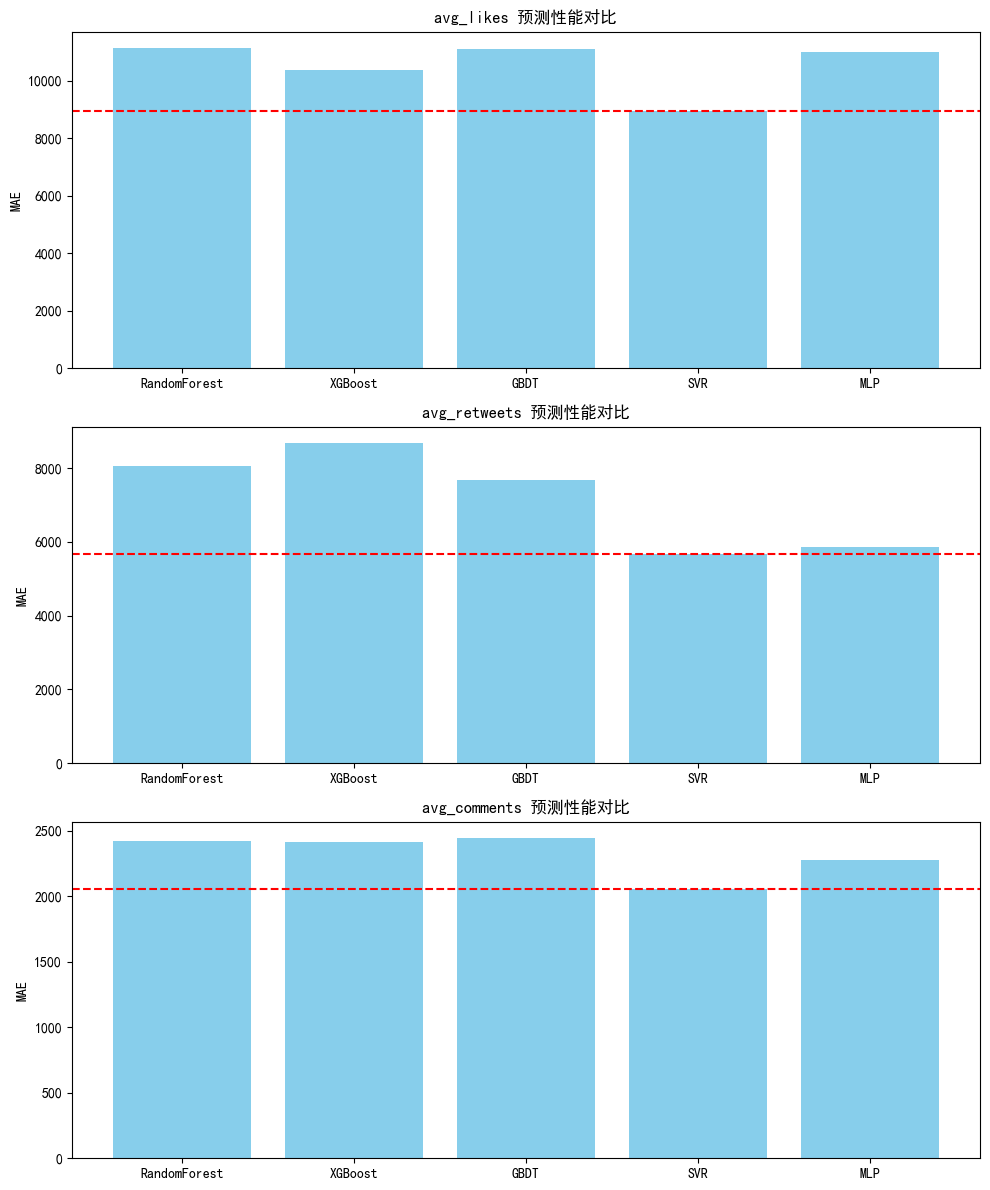

In [ ]:
import matplotlib.pyplot as plt

# 6. 模型对比可视化
def plot_model_comparison(model_results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    for idx, target in enumerate(model_results.keys()):
        model_names = list(model_results[target].keys())
        mae_values = [m['avg_mae'] for m in model_results[target].values()]

        axes[idx].bar(model_names, mae_values, color='skyblue')
        axes[idx].set_title(f'{target} 预测性能对比')
        axes[idx].set_ylabel('MAE')
        axes[idx].axhline(y=min(mae_values), color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

plot_model_comparison(model_results)

In [ ]:
def create_time_series_features(df, time_col='发布时间'):
    """创建时间序列特征（增强健壮性版本）"""
    # 1. 检查时间列是否存在
    if time_col not in df.columns:
        # 尝试自动识别时间列
        possible_time_cols = [col for col in df.columns if '时间' in col or 'time' in col.lower()]
        if not possible_time_cols:
            raise KeyError(f"数据中找不到时间列，尝试的列名: {time_col}")
        time_col = possible_time_cols[0]
        print(f"警告: 使用自动识别的时间列 '{time_col}' 替代 '{time_col}'")

    # 2. 确保时间列是datetime类型
    if not pd.api.types.is_datetime64_any_dtype(df[发布时间]):
        df[发布时间] = pd.to_datetime(df[发布时间], errors='coerce')
        # 检查转换结果
        if df[发布时间].isnull().any():
            print(f"警告: 时间列 '{发布时间}' 中存在无法解析的格式")

    # 3. 创建基础时间特征
    df = df.assign(
        year=df[time_col].dt.year,
        month=df[time_col].dt.month,
        week=df[time_col].dt.isocalendar().week,
        day_of_week=df[time_col].dt.dayofweek,
        hour=df[time_col].dt.hour  # 新增小时特征
    )

    # 4. 节假日标记（增强版）
    def get_chinese_holidays(year):
        """生成中国节假日日期列表"""
        holidays = {
            '元旦': [f"{year}-01-01"],
            '春节': [  # 春节假期（假设7天）
                f"{year}-01-28", f"{year}-01-29", f"{year}-01-30",
                f"{year}-01-31", f"{year}-02-01", f"{year}-02-02", f"{year}-02-03"
            ],
            '清明': [f"{year}-04-04", f"{year}-04-05", f"{year}-04-06"],
            '劳动节': [f"{year}-05-01", f"{year}-05-02", f"{year}-05-03"],
            '端午': [f"{year}-06-10", f"{year}-06-11", f"{year}-06-12"],
            '中秋': [f"{year}-09-17", f"{year}-09-18", f"{year}-09-19"],
            '国庆': [  # 国庆假期（7天）
                f"{year}-10-01", f"{year}-10-02", f"{year}-10-03",
                f"{year}-10-04", f"{year}-10-05", f"{year}-10-06", f"{year}-10-07"
            ]
        }
        return [date for dates in holidays.values() for date in dates]

    # 获取数据涉及的年份
    years = df[time_col].dt.year.unique()
    holiday_dates = []
    for year in years:
        holiday_dates.extend(get_chinese_holidays(year))

    df['is_holiday'] = df[time_col].dt.date.astype(str).isin(holiday_dates).astype(int)

    # 5. 添加是否周末特征
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # 6. 添加时间段特征（早上/下午/晚上）
    df['time_period'] = pd.cut(
        df[time_col].dt.hour,
        bins=[0, 6, 12, 18, 24],
        labels=['凌晨', '上午', '下午', '晚上'],
        right=False
    )

    return df

# 安全应用特征工程
try:
    ts_data = create_time_series_features(ts_data)
    print("时间序列特征创建成功！")
    print("新增特征:", [col for col in ts_data.columns if col not in ['发布时间', '微博正文']])
except Exception as e:
    print(f"特征工程失败: {str(e)}")
    # 这里可以添加回退方案

特征工程失败: '数据中找不到时间列，尝试的列名: 发布时间'


In [ ]:
time_col = "发布时间"
time_col

'发布时间'

In [ ]:
import pandas as pd
import requests

# 读取微博数据
try:
    df = pd.read_csv("weibo.csv", encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv("weibo.csv", encoding="gb18030")  # 中文备用编码

# 只保留需要的列，并去除正文为空的行
required_cols = ["微博id", "微博正文", "发布时间", "点赞数", "转发数", "评论数"]
df = df[required_cols].dropna(subset=["微博正文"]).reset_index(drop=True)

# 设置DeepSeek V3 API的相关参数
api_key = 'sk-2b397aed5f2f41bc9202c09824fee1b2'  # 替换成你的DeepSeek API密钥
api_url = 'https://api.deepseek.com/v3'  # 假设DeepSeek分类API的URL

# 提供的few-shot示例
few_shot_prompt = [
    {"text": "王者荣耀新皮肤发布，大家都来试试吧！", "label": 0},  # 皮肤
    {"text": "2025年电竞大赛，冠军争夺战！", "label": 1},  # 赛事
    {"text": "参加活动赢大奖，快来参与！", "label": 2},  # 活动
    {"text": "最新的广告宣传，快来看看！", "label": 3}   # 广告
]

# 定义一个函数，使用DeepSeek API对每条微博的正文进行分类
def classify_weibo_content(text):
    payload = {
        "api_key": api_key,
        "text": text,
        "few_shot_prompt": few_shot_prompt,
        "task": "classification"
    }
    response = requests.post(api_url, json=payload)

    if response.status_code == 200:
        result = response.json()
        return result.get('category')  # 假设返回的分类字段是 'category'
    else:
        print(f"请求失败，错误代码: {response.status_code}")
        return None

# 对微博正文进行分类
df['话题'] = df['微博正文'].apply(classify_weibo_content)

# 查看处理后的数据
print(df.head())


请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404
请求失败，错误代码: 404


KeyboardInterrupt: 

In [ ]:
payload = {
    "api_key": api_key,
    "text": "王者荣耀新皮肤发布，大家都来试试吧！",
    "task": "classification"
}

response = requests.post(api_url, json=payload)

print(response.status_code)
print(response.text)

404
{
  "error_msg": "Not Found. Please check the configuration."
}
